# Model Loader
Load in a saved model trained on the [Brown CCV cluster (OSCAR)](https://ccv.brown.edu/) and evaluate its accuracy on a subset of CUB-200.

In [1]:
from __future__ import print_function, division
import sys
import copy
import os
import datetime
import time
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torch
import os
from src.shared import gen_train_val

plt.ion()   # interactive mode

In [2]:
# for compatibility with old code
is_local = True

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset_name = "CUB_200"
# dataset_name = "CUB_200_2011/CUB_200_2011/images"
data_dir = f"datasets/{dataset_name}" if is_local else f"/users/tjiang12/data/tjiang12/{dataset_name}"
dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

val_size = int(0.3 * len(dataset))
train_size = len(dataset) - val_size

train_and_val = torch.utils.data.random_split(dataset, [train_size, val_size])

image_datasets = dict(zip(['train', 'val'], train_and_val))
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [classname.split('.')[1].replace('_', ' ') for classname in dataset.classes]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# path of weights transfered from CCV
PATH = "weights/TeacherTest_63pct"
model_loaded = models.resnet50()
num_ftrs = model_loaded.fc.in_features
model_loaded.fc = nn.Linear(num_ftrs, len(class_names))

model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                pred_status = "✔" if preds[j] == labels[j] else "✘, " + class_names[labels[j]]
                ax.set_title('{} ({})'.format(class_names[preds[j]], pred_status))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

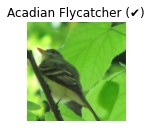

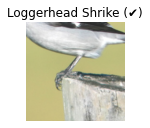

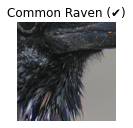

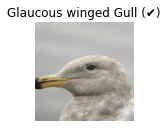

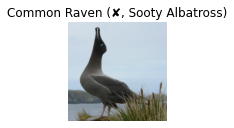

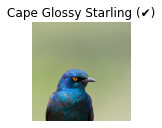

In [7]:
visualize_model(model_loaded)

In [12]:
# Experiment: Evaluate trained model's performance on unlabeled data
model_loaded.eval()

with torch.no_grad():
    running_corrects = 0
    seen = 0
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)

        outputs = model_loaded(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        seen += len(inputs)
        if i % 10 == 0:
            print("Accuracy", running_corrects, "/", seen, running_corrects / seen)
        if i > 50:
            break

Accuracy tensor(4) / 4 tensor(1.)
Accuracy tensor(37) / 44 tensor(0.8409)
Accuracy tensor(72) / 84 tensor(0.8571)
Accuracy tensor(104) / 124 tensor(0.8387)
Accuracy tensor(136) / 164 tensor(0.8293)
Accuracy tensor(164) / 204 tensor(0.8039)


In [ ]:
# Load larger unlabeled set (CUB 200 2011)
unlabeled_data_dir = "datasets/CUB_200"
unlabeled_dataset = datasets.ImageFolder(
    unlabeled_data_dir, data_transforms['train'])
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_and_val = torch.utils.data.random_split(dataset, [train_size, val_size])

unlabeled_image_datasets = dict(zip(['train', 'val'], train_and_val))
unlabeled_dataloaders = {x: torch.utils.data.DataLoader(unlabeled_image_datasets[x], batch_size=4,
                                              shuffle=True)
                         for x in ['train', 'val']}

In [ ]:
# Experiment: Evaluate trained model's performance on unlabeled data
model_loaded.eval()

with torch.no_grad():
    running_corrects = 0
    seen = 0
    for i, (inputs, labels) in enumerate(unlabeled_dataloaders['val']):
        inputs = inputs.to(device)

        reshaped = torch.reshape(inputs[0:1][0], (1,3,224,224))
        outputs = model_loaded(reshaped)
        
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data[0:1])
        seen += len(inputs[0:1])
        print("Accuracy", running_corrects, "/", seen, running_corrects / seen)